In [ ]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import librosa.display
from tqdm import tqdm
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'data/dev-clean'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'dev-clean.tar.gz',
      origin="https://www.openslr.org/resources/12/dev-clean.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

337936384/337926286 [==============================] - 19s 0us/step


In [ ]:
file_path = '/content/data/LibriSpeech/dev-clean/'
drive_path = '/content/drive/MyDrive/Sem_2_Hw_project/Company assignment/Voiceed/'

In [ ]:
file_names = tf.io.gfile.glob(str(pathlib.Path(file_path)) + '/*/*/*.flac')
len(file_names)

2703

## Extract MFCC and will store in json


First let's extract the metadata of speaker from SPEAKERS.TXT

In [ ]:
f = open('/content/data/LibriSpeech/SPEAKERS.TXT', encoding='UTF-8')
lines = f.readlines()

In [ ]:
speker_information = {}

In [ ]:
for row in lines[12:]:
  speker_information[row.split('|')[0].strip()]= row.split('|')[1].strip()
  # speker_information['SEX'].append(row.split('|')[1].strip())
  # speker_information['MINUTES'].append(row.split('|')[3].strip())
  # speker_information['NAME'].append(row.split('|')[4].strip())

In [ ]:
signal, sr = librosa.load(path=file_names[0], sr=22050)

In [ ]:
n_fft = 2048
n_mfcc = 13
hop_length = 512

In [ ]:
# As our signal length is different, To cap the signal let's have a histogram to understand the length
s = []
for name in tqdm(file_names):
  signal, sr = librosa.load(path=name, sr=22050)
  s.append(len(signal))

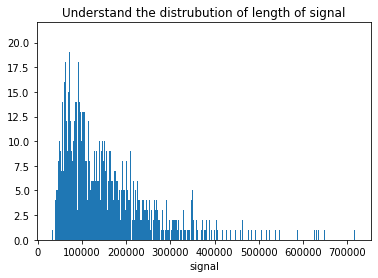

In [ ]:
plt.hist(s, bins=1000)
plt.xlabel('signal')
plt.title("Understand the distrubution of length of signal")
plt.show()

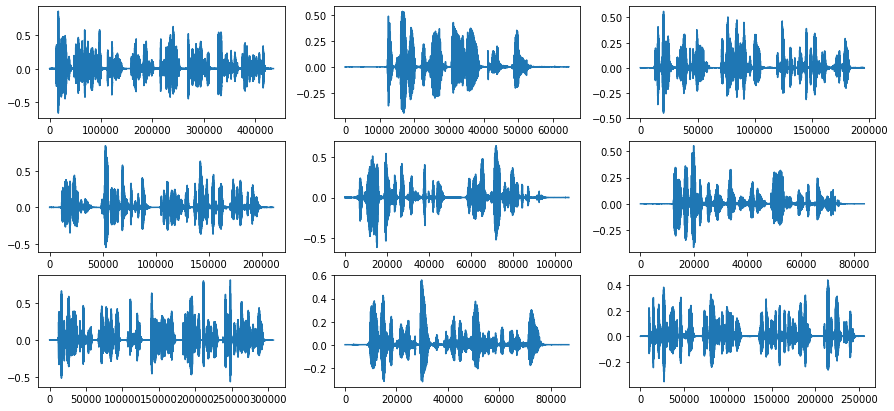

In [ ]:
plt.figure(figsize=(15,7))
for idx, name in enumerate(file_names[:9]):
  signal, sr = librosa.load(path=name, sr=22050)
  plt.subplot(3, 3, idx+1)
  plt.plot(signal)
plt.show()

In [ ]:
from IPython.display import Audio

Audio(signal, rate =sr)

In [ ]:
print(f"Out of {len(file_names)} we have {(np.array(s)<300000).sum()/len(file_names)} % having len less than 300000")

In [ ]:
def get_cap_signal(name, cap_length):
  signal, sr = librosa.load(path=name, sr=22050)
  len_signal = len(signal)

  if len_signal>cap_length:
    signal = signal[:cap_length]
  else:
    signal = np.concatenate((signal , np.zeros(shape=(cap_length-len_signal), dtype='float32')), axis = 0)
  return signal, sr

In [ ]:
def get_label(name, speker_information):
    return speker_information[name.split('/')[-3]]

In [ ]:
# Okay we will cap 
mfcc_json = {'MFCC':[],
             'Label':[]}
cap_length = 300000
for name in tqdm(file_names[:]):
  signal, sr = get_cap_signal(name, cap_length)
  label = get_label(name, speker_information)

  mfcc = librosa.feature.mfcc(signal, sr = sr, n_fft = n_fft, n_mfcc=n_mfcc, hop_length = hop_length)

  mfcc_json['MFCC'].append(mfcc)
  mfcc_json['Label'].append(label)

100%|██████████| 2703/2703 [10:16<00:00,  4.39it/s]


In [ ]:
mfcc_json.keys()

dict_keys(['MFCC', 'Label'])

In [ ]:
df = pd.DataFrame()
df['MFCC'] = mfcc_json['MFCC']
df['Label'] = mfcc_json['Label']
df.to_json(drive_path+'All_train_data.json')

## Read the MFCC features

In [ ]:
from ast import literal_eval
df = pd.read_json(drive_path+'All_train_data.json')

In [ ]:
# Preprocess data after reading from json
ll = []
for j in df['MFCC']:
  ll.append(np.array(j))
np.array(ll).shape

df['Label'].replace({'F':0, 'M':1}, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(ll),  np.array(df['Label']).reshape(-1,1), test_size = 0.25)

In [ ]:
x_train.shape, y_train.shape

((2027, 13, 586), (2027, 1))

In [ ]:
## Hyerparameters for NN
batch_size = 64

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
train_ds = train_ds.batch(batch_size=batch_size).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras

In [ ]:
def plot_history(history):
    train_loss =  history.history['loss']
    train_acc =  history.history['accuracy']
    val_loss =  history.history['val_loss']
    val_acc =  history.history['val_accuracy']

    fig = plt.figure(figsize=(15,5))
    plt.plot( train_loss, label='Training loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(15,5))
    plt.plot( val_acc, label='Vali acc')
    plt.plot(train_acc, label='Training acc')
    plt.legend()
    plt.show()

### Model 1

In [ ]:
input = keras.Input(shape=(x_train.shape[1],x_train.shape[2]))

x = keras.layers.Flatten()(input)
x = keras.layers.Dense(500, 'relu')(x)
x = keras.layers.Dense(250, 'relu')(x)
x = keras.layers.Dense(150, 'relu')(x)
output = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 586)]         0         
                                                                 
 flatten (Flatten)           (None, 7618)              0         
                                                                 
 dense (Dense)               (None, 500)               3809500   
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 150)               37650     
                                                                 
 dense_3 (Dense)             (None, 2)                 302       
                                                                 
Total params: 3,972,702
Trainable params: 3,972,702
Non-train

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=100)

Epoch 1/100
32/32 [==============================] - 3s 50ms/step - loss: 122.0543 - accuracy: 0.5550 - val_loss: 6.1597 - val_accuracy: 0.6864
Epoch 2/100
32/32 [==============================] - 1s 44ms/step - loss: 21.3906 - accuracy: 0.6379 - val_loss: 28.7545 - val_accuracy: 0.5814
Epoch 3/100
32/32 [==============================] - 1s 44ms/step - loss: 10.4417 - accuracy: 0.7178 - val_loss: 11.9441 - val_accuracy: 0.6642
Epoch 4/100
32/32 [==============================] - 1s 44ms/step - loss: 3.3972 - accuracy: 0.8086 - val_loss: 3.9136 - val_accuracy: 0.7485
Epoch 5/100
32/32 [==============================] - 1s 45ms/step - loss: 2.9680 - accuracy: 0.8096 - val_loss: 16.6500 - val_accuracy: 0.5518
Epoch 6/100
32/32 [==============================] - 1s 45ms/step - loss: 4.1133 - accuracy: 0.7933 - val_loss: 24.7564 - val_accuracy: 0.5266
Epoch 7/100
32/32 [==============================] - 1s 44ms/step - loss: 6.3920 - accuracy: 0.7563 - val_loss: 5.4056 - val_accuracy: 0.754

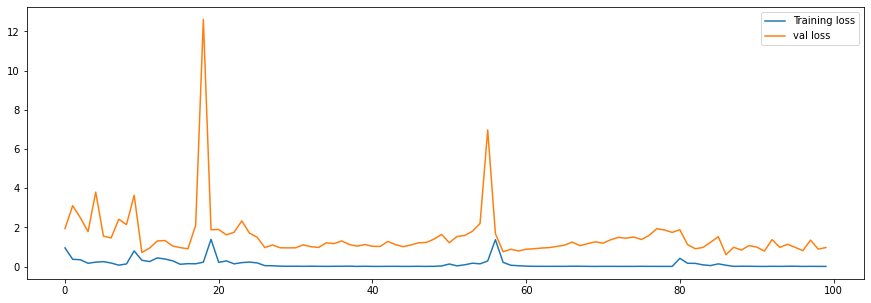

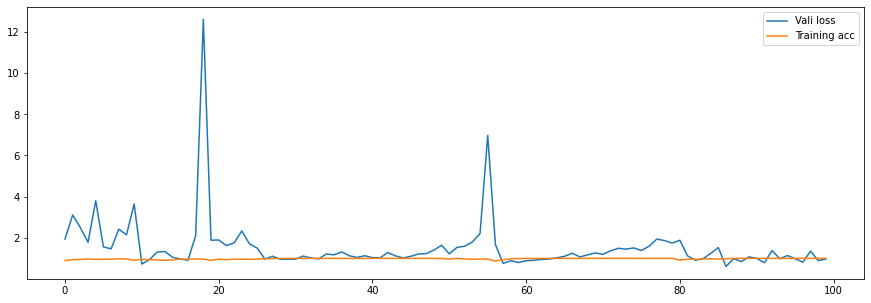

In [ ]:
plot_history(history)

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.951144,0.891959,1.937421,0.823964
1,0.369103,0.938826,3.107271,0.763314
2,0.346922,0.944746,2.490172,0.788462
3,0.166554,0.964973,1.780139,0.857988
4,0.223123,0.949186,3.797667,0.772189
...,...,...,...,...
95,0.014418,0.993587,0.979619,0.847633
96,0.004938,0.999013,0.810954,0.865385
97,0.010607,0.995067,1.349058,0.834320
98,0.006380,0.997533,0.888436,0.868343


## Model 2
 We will regularize the previous layer from model1

In [ ]:
input = keras.Input(shape=(x_train.shape[1],x_train.shape[2]))

x = keras.layers.Flatten()(input)
x = keras.layers.Dense(500, 'relu',keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(250, 'relu', keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(150, 'relu', keras.regularizers.l2(0.001))(x)
output = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(input, output)

model.compile(optimizer= keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 45ms/step - loss: 101.0741 - accuracy: 0.5703 - val_loss: 50.5363 - val_accuracy: 0.5104
Epoch 2/100
32/32 [==============================] - 1s 42ms/step - loss: 14.5504 - accuracy: 0.6764 - val_loss: 8.8687 - val_accuracy: 0.6997
Epoch 3/100
32/32 [==============================] - 1s 42ms/step - loss: 9.8544 - accuracy: 0.7109 - val_loss: 4.0044 - val_accuracy: 0.7825
Epoch 4/100
32/32 [==============================] - 1s 41ms/step - loss: 2.6366 - accuracy: 0.8165 - val_loss: 12.6355 - val_accuracy: 0.5784
Epoch 5/100
32/32 [==============================] - 1s 41ms/step - loss: 2.1711 - accuracy: 0.8421 - val_loss: 18.4305 - val_accuracy: 0.5340
Epoch 6/100
32/32 [==============================] - 1s 41ms/step - loss: 4.0123 - accuracy: 0.8012 - val_loss: 3.9006 - val_accuracy: 0.7515
Epoch 7/100
32/32 [==============================] - 1s 42ms/step - loss: 2.5637 - accuracy: 0.8288 - val_loss: 7.8641 - val_accuracy: 0.6612


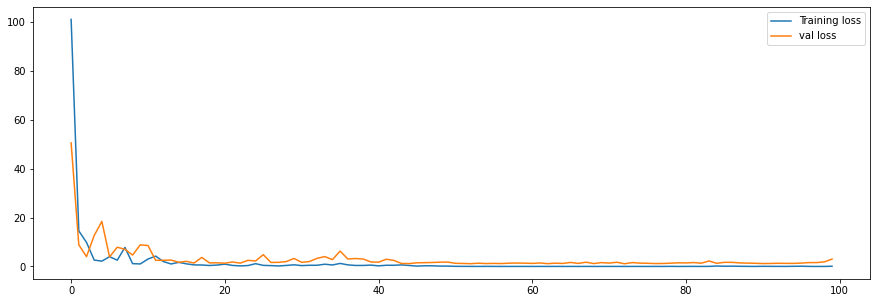

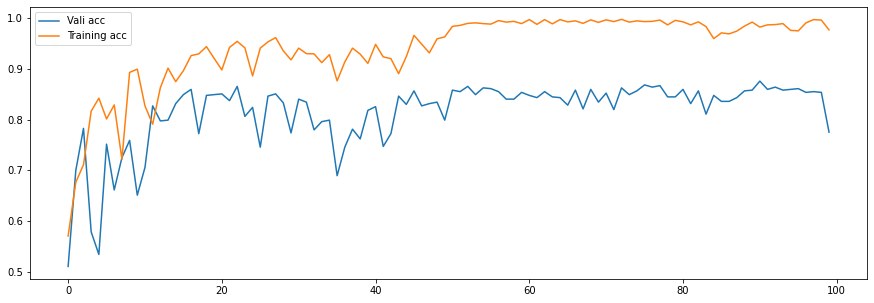

In [ ]:
plot_history(history)

## Model 3

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(ll),  np.array(df['Label']).reshape(-1,1), test_size = 0.25, 
                                                    stratify=np.array(df['Label']))
x_train = x_train[... , np.newaxis]
x_test = x_test[..., np.newaxis]

In [ ]:
## Hyerparameters for NN
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = train_ds.batch(batch_size=batch_size).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 13, 586, 1), (None, 1)), types: (tf.float64, tf.int64)>

In [ ]:
input = keras.Input(shape = (13, 586, 1))

x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(input)
x = keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalMaxPool2D()(x)

x = keras.layers.Dense(100, activation='relu')(x)
output = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 586, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 7, 293, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 147, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 147, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 74, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 37, 128)       0     

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks = [keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
32/32 [==============================] - 8s 231ms/step - loss: 0.4814 - accuracy: 0.8012 - val_loss: 1.3928 - val_accuracy: 0.5015
Epoch 2/20
32/32 [==============================] - 7s 221ms/step - loss: 0.1424 - accuracy: 0.9492 - val_loss: 0.7270 - val_accuracy: 0.6893
Epoch 3/20
32/32 [==============================] - 7s 223ms/step - loss: 0.0657 - accuracy: 0.9832 - val_loss: 0.6610 - val_accuracy: 0.6953
Epoch 4/20
32/32 [==============================] - 7s 222ms/step - loss: 0.0367 - accuracy: 0.9921 - val_loss: 0.2245 - val_accuracy: 0.9068
Epoch 5/20
32/32 [==============================] - 7s 221ms/step - loss: 0.0339 - accuracy: 0.9941 - val_loss: 0.4272 - val_accuracy: 0.8195
Epoch 6/20
32/32 [==============================] - 7s 223ms/step - loss: 0.0404 - accuracy: 0.9852 - val_loss: 0.1110 - val_accuracy: 0.9556
Epoch 7/20
32/32 [==============================] - 7s 222ms/step - loss: 0.0229 - accuracy: 0.9961 - val_loss: 0.2145 - val_accuracy: 0.9083
Epoch 

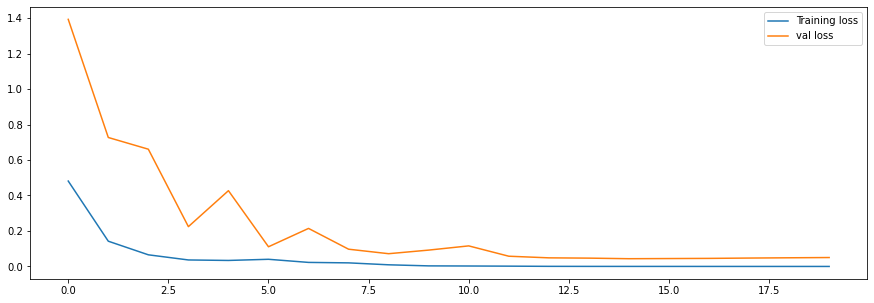

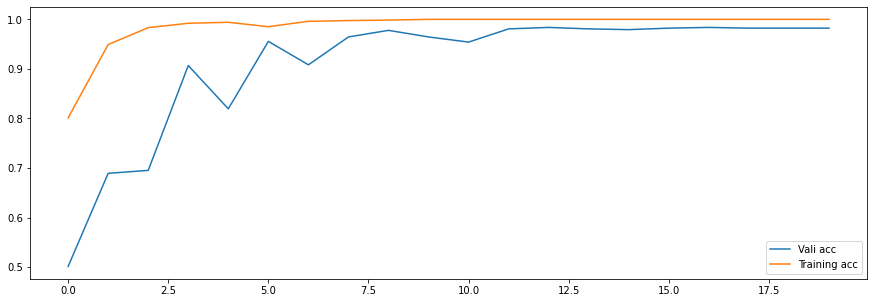

In [ ]:
plot_history(history)

You can refer my notebook about intuition from my previous notebook [Evaluation method for classification](https://www.kaggle.com/ramsegaurav/evaluation-methods-for-classification-from-scratch).

## Part 2

In [ ]:
!pip install fairseq

In [ ]:
import torch
import fairseq

In [ ]:
!wget https://dl.fbaipublicfiles.com/fairseq/wav2vec/wav2vec_small.pt

--2021-11-29 13:42:04--  https://dl.fbaipublicfiles.com/fairseq/wav2vec/wav2vec_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 950500491 (906M) [application/octet-stream]
Saving to: ‘wav2vec_small.pt.3’

wav2vec_small.pt.3  100%[===================>] 906.47M  82.8MB/s    in 11s     

2021-11-29 13:42:14 (84.3 MB/s) - ‘wav2vec_small.pt.3’ saved [950500491/950500491]



In [ ]:
cp_path = '/content/wav2vec_small.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]

In [ ]:
# using multiprocessing significantly decreased processing time

In [ ]:
global feature_json
feature_json = {'feature':[],
             'Label':[]}

def multipro(name):
  signal, sr = librosa.load(path=name, sr=22050)
  chunks = int(np.ceil(len(signal)/sr))
  l = []
  for i in range(chunks):
      a = i*sr
      b = a+sr
      temp_s = signal[a:b]
      # print(len(temp_s))
      len_temp_s = len(temp_s)
      if len_temp_s < sr:
          temp_s = np.concatenate((temp_s , np.zeros(shape=(sr-len_temp_s), dtype='float32')), axis = 0)
      feat = model.feature_extractor(torch.Tensor(np.reshape(temp_s, (1, sr)))).squeeze().detach().numpy()
      label = get_label(name, speker_information)
      # print('here')
      l.append([feat, label])
      # feature_json['feature'].append(feat)
      # feature_json['Label'].append(label)
  return l

In [ ]:
%%time

import multiprocessing
sss = 100
for idx in tqdm(range(27)):

    pool = multiprocessing.Pool()
    a = pool.map(multipro, file_names[idx*sss:idx*sss + sss])
    pool.close()

    feature_json = {'feature':[],
                'Label':[]}
    for i in a:
      for j in i:
        feature_json['feature'].append(j[0])
        feature_json['Label'].append(j[1])

    df = pd.DataFrame()
    df['MFCC'] = feature_json['feature']
    df['Label'] = feature_json['Label']
    df.to_json(drive_path+'json_files/'+f'Using_pretrained_vectors{idx}.json')

100%|██████████| 27/27 [51:48<00:00, 115.13s/it]

CPU times: user 2min 15s, sys: 1min 8s, total: 3min 24s
Wall time: 51min 48s
